In [1]:
import numpy as np
import laspy
from TronGisPy import GisIO, CRS, Normalizer, Interpolation
import CSF 
import os, sys, gc, subprocess # file system package
import pickle, json, shutil, itertools # file processing basic package
import laspy, PySaga, gdal # geo package
#import cv2 # open computer vision package
import pandas as pd
import geopandas as gpd
import numba
# csf = CSF.CSF()
from scipy.stats import entropy
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances, pairwise_distances_argmin
from util.las import *
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [2]:
%%time
las_fp = os.path.join("data", "123.las")
clipped_las_fp = os.path.join("tmp", "clipped_classified_ground.las")

X_ref_fp = "./tmp/clipped_X_ref.tif"
# las_classified_path = "./tmp/classified_ground.las"
street_las = CloudPoint(las_fp)
clipped_las = CloudPoint(clipped_las_fp)

Wall time: 9.72 s


In [3]:
resolution = 0.05
pad = resolution / 2
x_min, x_max, y_min, y_max = clipped_las.get_las_boundary(return_poly=False)
x_min, x_max = x_min - pad, x_max + pad
y_min, y_max = y_min - pad, y_max + pad
geo_transform = (x_min, resolution, 0, y_max, 0, -resolution)
wkt_3826 = CRS.get_wkt_from_epsg(3826)
cols = int((x_max - x_min) // resolution) + 1
rows = int((y_max - y_min) // resolution) + 1
X = np.random.rand(rows, cols)
GisIO.write_output_tif(X, X_ref_fp, geo_transform=geo_transform, projection=wkt_3826, gdaldtype=gdal.GDT_Float32)
X_ref = GisIO.get_nparray(X_ref_fp)
print(X_ref.shape)

(1700, 1867, 1)


In [4]:
%%time


las_data = np.array([clipped_las.data[i] for i in clipped_las.using_attr]).T
X_ref = GisIO.get_nparray(X_ref_fp)
cols, rows, bands, _, _, _, _ = GisIO.get_geo_info(X_ref_fp)
X_ref_extent = GisIO.get_extent(X_ref_fp, False)

las_npidxs = CRS.numba_transfer_group_coord_to_npidx(las_data, geo_transform) # Wall time: 35 s
las_npidxs, las_npidxs.shape

Wall time: 18.5 s


(array([[1100,  412],
        [1113,  457],
        [1107,  419],
        ...,
        [ 259,  916],
        [ 254, 1037],
        [ 237,  980]], dtype=int64),
 (13632239, 2))

In [5]:
idxs_sample = np.random.choice(range(len(las_data)), size=500000)
las_data_sample = las_data[idxs_sample]

df = gpd.GeoDataFrame([Point(p) for p in las_data_sample[:, :2]], columns=['geometry'], geometry='geometry')
df['intensity'] = las_data_sample[:, 5]

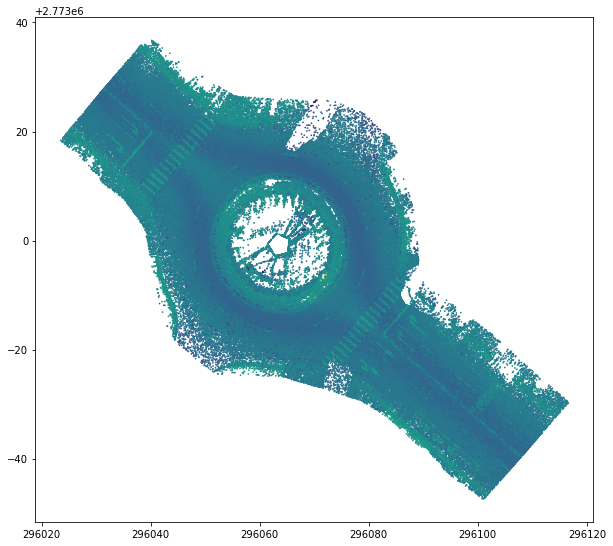

In [6]:
figsize = (10, 10)
fig, ax = plt.subplots(1,1, figsize=figsize)
df.plot(column='intensity', ax=ax, markersize=0.5)

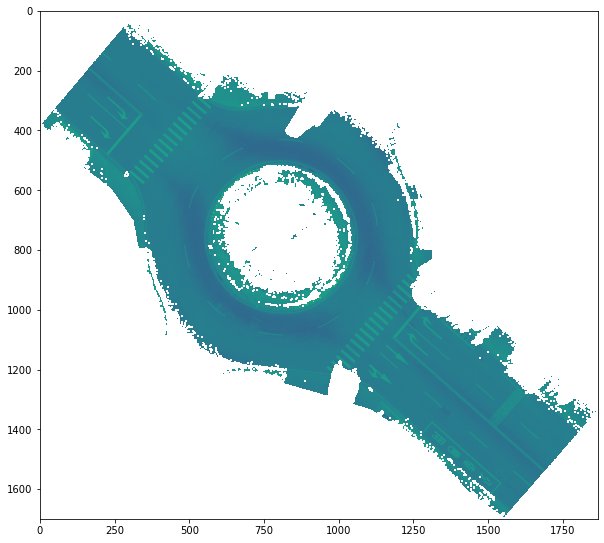

In [10]:
fig, ax = plt.subplots(1,1, figsize=figsize)
clipped_max = clipped_las.proj_las_to_2D_plane(las_npidxs, X_ref[:,:,0], feature='intensity', operator='max' )
ax.imshow(clipped_max)

C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


,0,1,2,3,4,5,6,7,8,9,10
value,143.0,1530.6,2918.2,4305.8,5693.4,7081.0,8468.6,9856.2,11243.8,12631.4,14019.0
counts,294.0,694.0,3310.0,244230.0,787962.0,160159.0,515.0,54.0,78.0,374.0,NaN


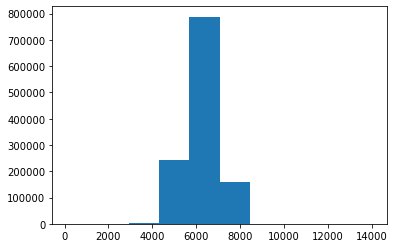

In [8]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format}) 
results = plt.hist(clipped_max.flatten())

pd.DataFrame([results[1], results[0]], index=["value", "counts"])

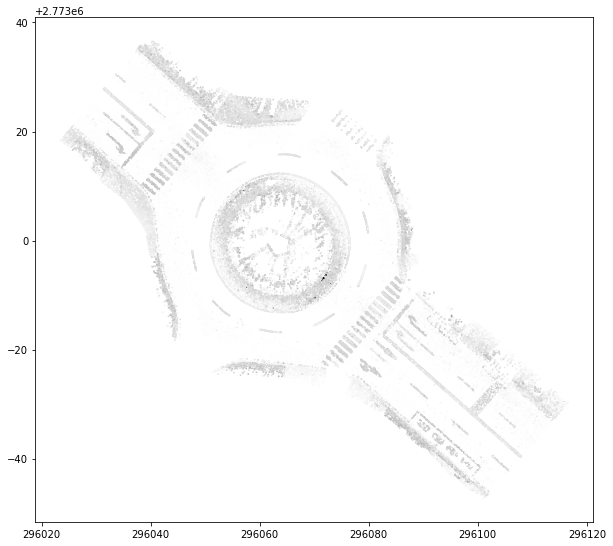

In [9]:
fig, ax = plt.subplots(1,1, figsize=figsize)
df[df["intensity"] > 6000].plot(column='intensity', ax=ax, markersize=0.5, cmap="gray_r")

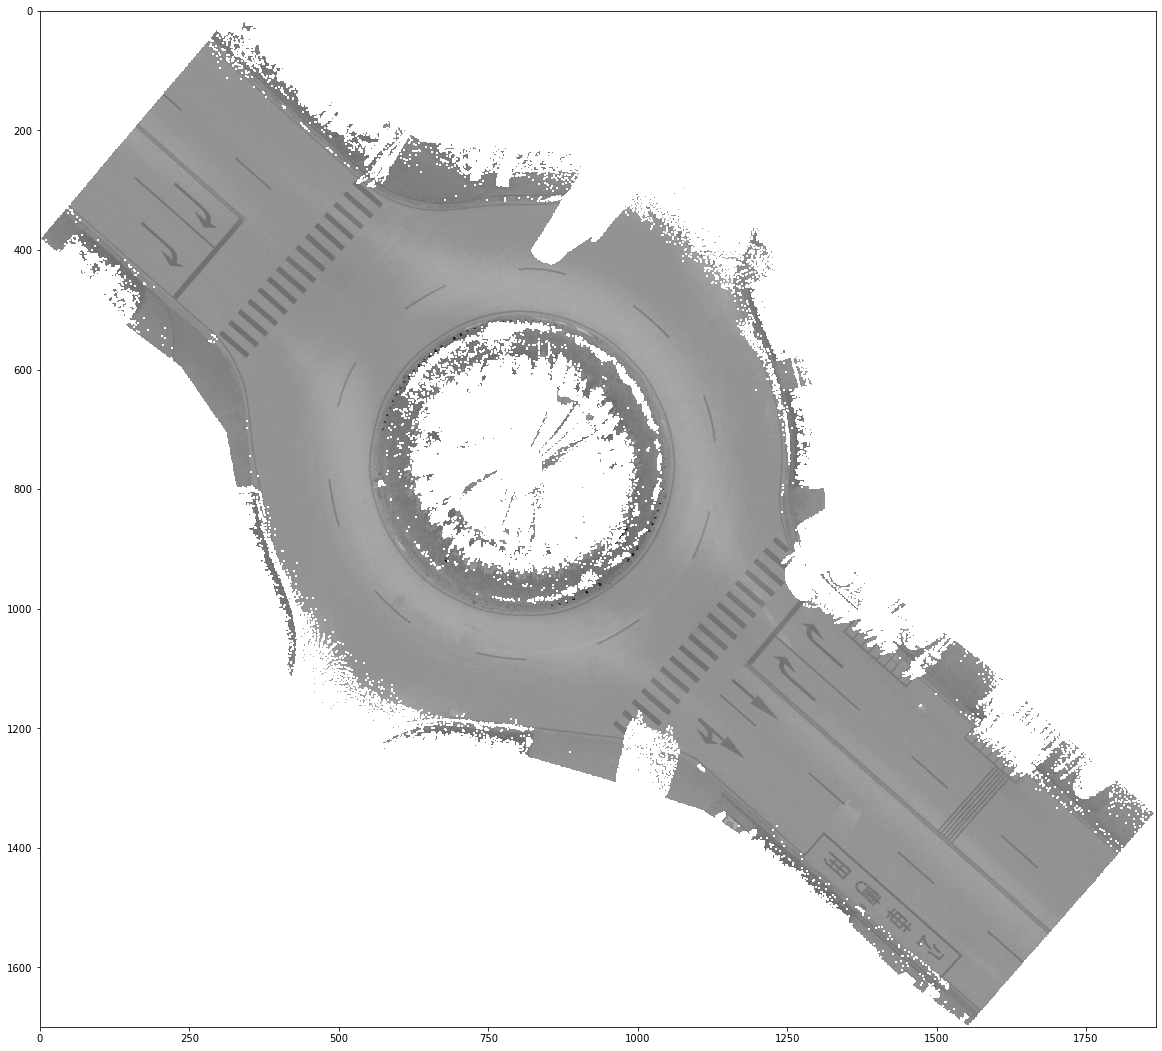

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(clipped_max, cmap="gray_r")



C:\Users\TTL_R041\anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


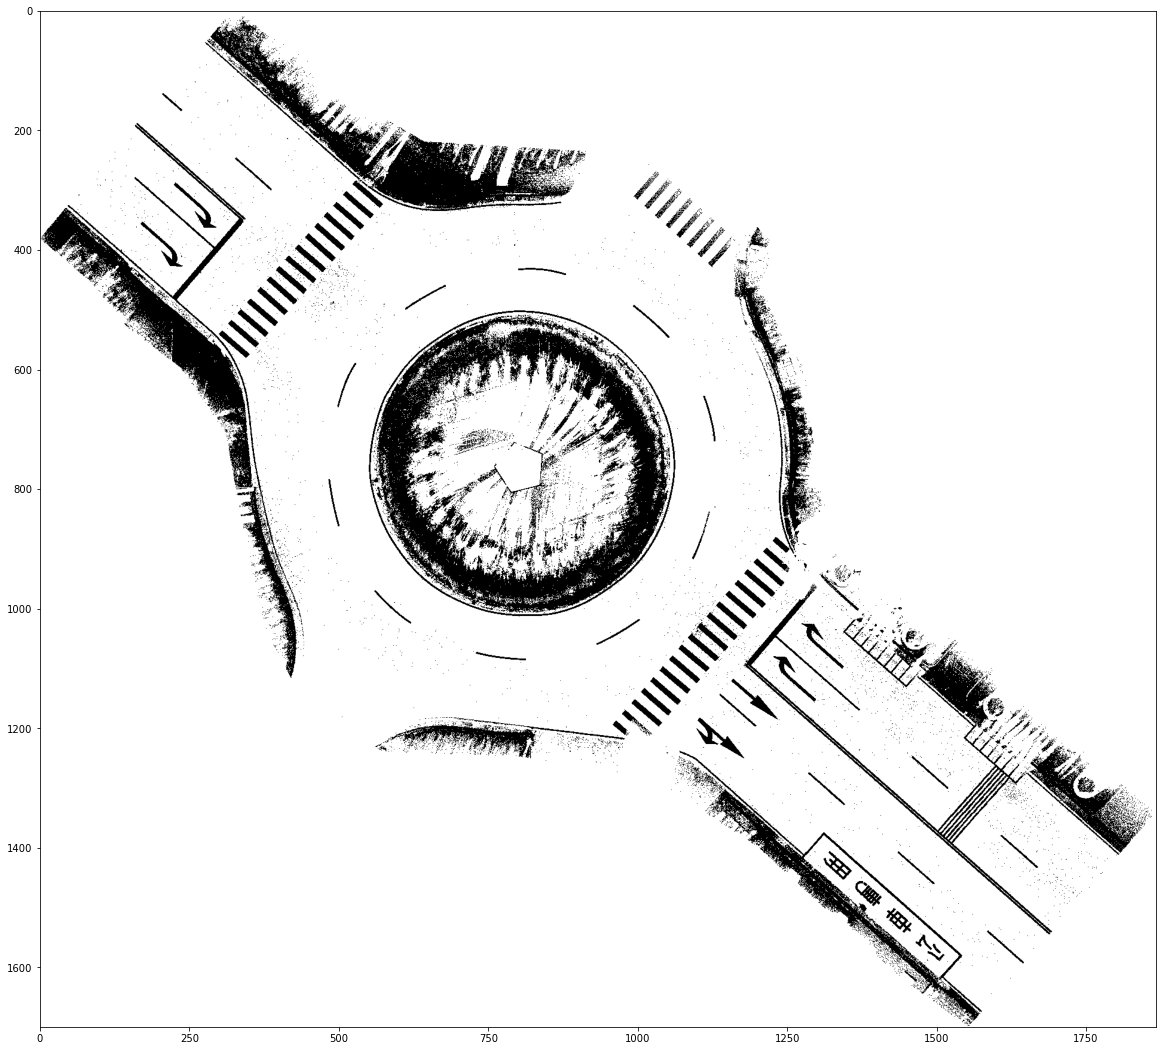

In [11]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

clipped_max_copy = clipped_max.copy()
clipped_max_copy[clipped_max<6500] = 0
# clipped_max_copy[clipped_max<6000] = 0
clipped_max_copy[np.isnan(clipped_max_copy)] = 0

zero_idx = np.array(clipped_max_copy==0)
non_zero_idx = np.array(clipped_max_copy!=0)
clipped_max_copy[zero_idx] = 0
clipped_max_copy[non_zero_idx] = 1

ax.imshow(clipped_max_copy, cmap="gray_r")



In [109]:
# dbscan = DBSCAN(eps=2, min_samples=1.7)
# dbscan = dbscan.fit(xyz)
# clusters = dbscan.labels_


clustering = DBSCAN(eps=3, min_samples=2).fit(clipped_max_copy)
clustering.labels_
## array([ 0,  0,  0,  1,  1, -1])
# clustering
## DBSCAN(eps=3, min_samples=2)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [71]:
from scipy.ndimage.measurements import label

n_thresh = 8
labeled_array, num_features = label(clipped_max_copy)
binc = np.bincount(labeled_array.ravel())
noise_idx = np.where(binc <= n_thresh)
mask = np.in1d(labeled_array, noise_idx).reshape(clipped_max_copy.shape)
clipped_max_copy[mask] = 0




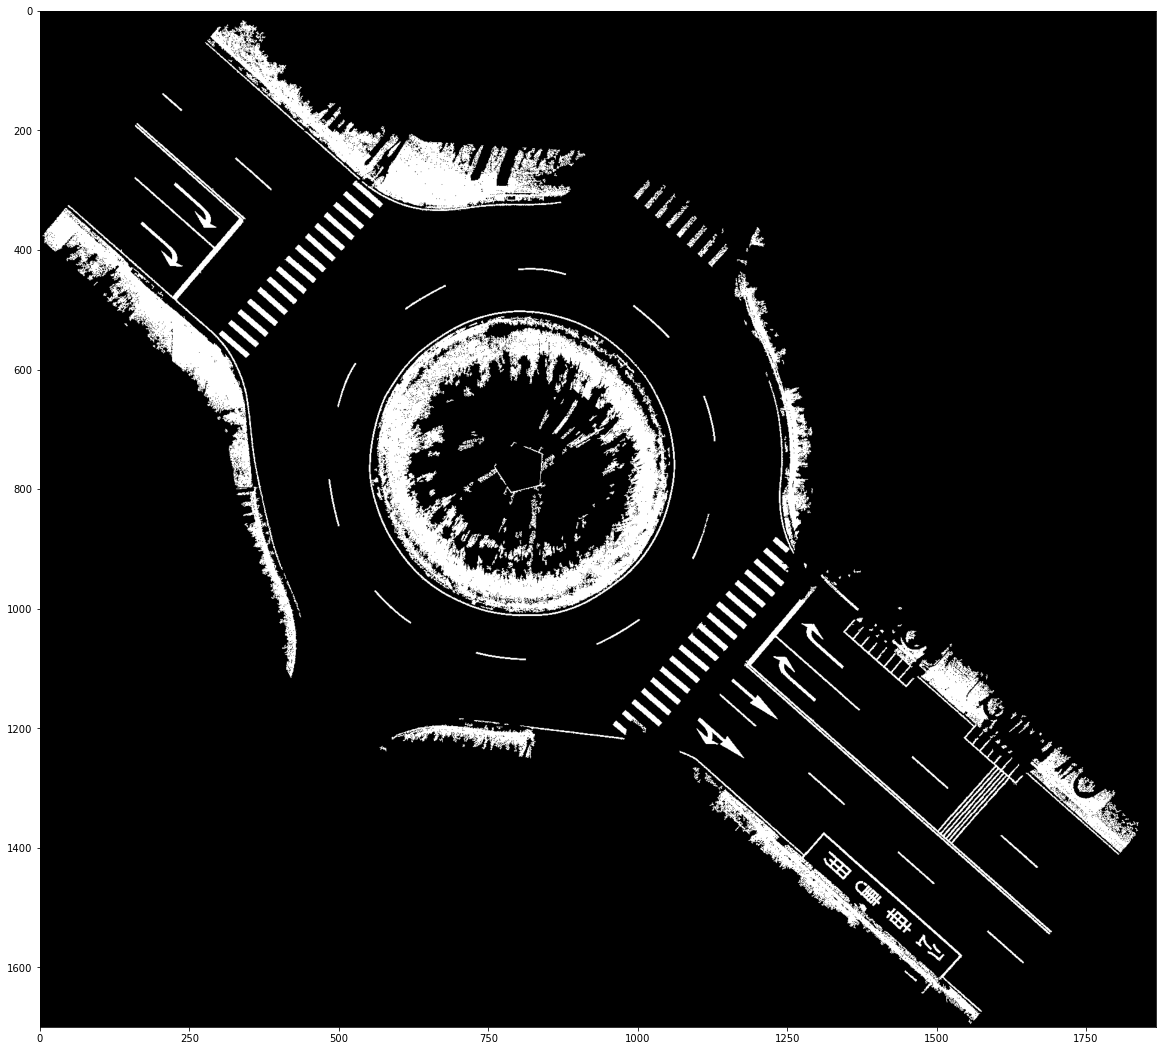

In [84]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(clipped_max_copy, cmap="gray")
ttt = clipped_max_copy.copy()
ttt[ttt==0]=-1
GisIO.write_output_tif(ttt, "tmp/filter_results.tif", geo_transform=geo_transform, projection=wkt_3826,
    gdaldtype=gdal.GDT_Int32, no_data_value=-1)

In [73]:
clipped_max_labbled = np.argwhere(clipped_max_copy==1)

In [53]:
# fig, ax = plt.subplots(1,1, figsize=(20, 20))
# DBSCAN_clipped = np.zeros_like(clipped_max_copy)

# dbscan = DBSCAN(eps=2, min_samples=1.7)
# dbscan = dbscan.fit(clipped_max_copy)
# clusters = dbscan.labels_
# # clipped_filtered = clipped_max_copy.copy()

# # clipped_filtered[clipped_max_copy == -1] = 0
# # DBSCAN_clipped[clipped_max_copy != -1] = 1

# # las_data_classfy_outlier[:, 6][clusters == -1] = 0
# #         las_data_classfy_outlier[:, 6][clusters != -1] = 1
    
    
# # ax.imshow(clipped_filtered, cmap="gray_r")

# # plt.hist(DBSCAN_clipped.flatten())
# np.sum(DBSCAN_clipped)

# # filter outliers
# #         las_data_filtered = las_data[clusters!=-1].copy()
# #         write_las_data(las_data_filtered, las_filtered_fp, scale)
        
# #         # classify outlier
# #         las_data_classfy_outlier = las_data.copy()
# #         las_data_classfy_outlier[:, 6][clusters == -1] = 0
# #         las_data_classfy_outlier[:, 6][clusters != -1] = 1
# #         las_data_classfy_outlier[:, -3:][clusters == -1] = 0
# clusters.shape







# read data
xy = clipped_max_labbled.copy()

# clustering
dbscan = DBSCAN(eps=2, min_samples=1.7)
dbscan = dbscan.fit(xy)
clusters = dbscan.labels_
print(clusters.shape)
# filter outliers
las_data_filtered = clipped_max_labbled[clusters!=-1].copy()
# write_las_data(las_data_filtered, las_filtered_fp, scale)

# # classify outlier
# las_data_classfy_outlier = clipped_max_labbled.copy()
# las_data_classfy_outlier[:, 6][clusters == -1] = 0
# las_data_classfy_outlier[:, 6][clusters != -1] = 1
# las_data_classfy_outlier[:, -3:][clusters == -1] = 0

(254518,)


In [54]:
# outFile = laspy.file.File(filename='./tmp/filtered_colud.las', mode="w", 
#                           header=laspy.header.Header(point_format=2)) # LAS point format 2 supports color

# outFile.header.offset = clipped_las.header[0]
# outFile.header.scale = clipped_las.header[1]
# outFile.intensity = clipped_las["intensity"][np.argwhere(clusters!=-1)[:,0]]
# outFile.x = clipped_las["x"][np.argwhere(clusters!=-1)[:,0]]
# outFile.y = clipped_las["y"][np.argwhere(clusters!=-1)[:,0]]
# outFile.z = clipped_las["z"][np.argwhere(clusters!=-1)[:,0]]
# outFile.close()


In [49]:
outFile = laspy.file.File(filename='./tmp/filtered1.las', mode="w", 
                          header=laspy.header.Header(point_format=2)) # LAS point format 2 supports color

outFile.header.offset = clipped_las.header[0]
outFile.header.scale = clipped_las.header[1]
outFile.intensity = clipped_las["intensity"][np.argwhere(clusters!=-1)[:,0]]
outFile.x = clipped_las["x"][np.argwhere(clusters!=-1)[:,0]]
outFile.y = clipped_las["y"][np.argwhere(clusters!=-1)[:,0]]
outFile.z = clipped_las["z"][np.argwhere(clusters!=-1)[:,0]]
outFile.close()


In [55]:
clusters

array([  0,   0,   0, ..., 397, 397, 397], dtype=int64)

(array([80640.00, 96437.00, 2703.00, 3263.00, 1825.00, 2285.00, 29374.00,
        11993.00, 21622.00, 4376.00]),
 array([0.00, 39.70, 79.40, 119.10, 158.80, 198.50, 238.20, 277.90, 317.60,
        357.30, 397.00]),
 <a list of 10 Patch objects>)

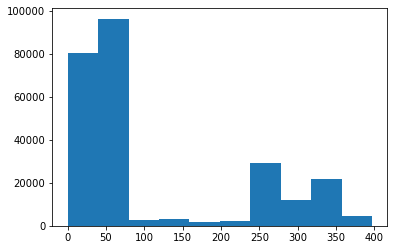

In [56]:
plt.hist(clusters)

In [58]:
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_clusters_

398

In [ ]:
# lines = []

# for cluster in range(n_clusters_):
#     sub_cluster_df = cluster_df[cluster_df["Group"] == cluster]
#     points = sub_cluster_df[["Easting","Northing", "Altitude"]].values
#     distances = squareform(pdist(points))
#     for i in range(0,15):
#         max_index = np.argmax(distances)
#         i1, i2 = np.unravel_index(max_index, distances.shape)
#         distances[i1,i2] = 0.0
#     max_dist = np.max(distances)
#     max_index = np.argmax(distances)
#     i1, i2 = np.unravel_index(max_index, distances.shape)
#     p1 = sub_cluster_df.iloc[i1]
#     p2 = sub_cluster_df.iloc[i2]
#     lines.append(([p1["Easting"], p2["Easting"]],[p1["Northing"], p2["Northing"]], [p1["Altitude"], p2["Altitude"]]))

In [ ]:
plt.figure(figsize=(20,10))
plt.xlim(70, 130), plt.ylim(20,120)

for l in lines:
    plt.plot(l[0], l[1], l[2])
    
plt.show()

print("Number of prototype lane markings: ", len(lines))

In [61]:
clusters.shape

(254518,)

In [65]:
np.argwhere(clipped_max_copy!=0).shape

(254518, 2)

In [87]:
GisIO.polygonize_layer("tmp/filter_results.tif", "tmp/filter_results.shp")

In [80]:
clipped_max_copy

array([[0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       ...,
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00]])

In [88]:
df_filter = gpd.read_file("./tmp/filter_results.shp")

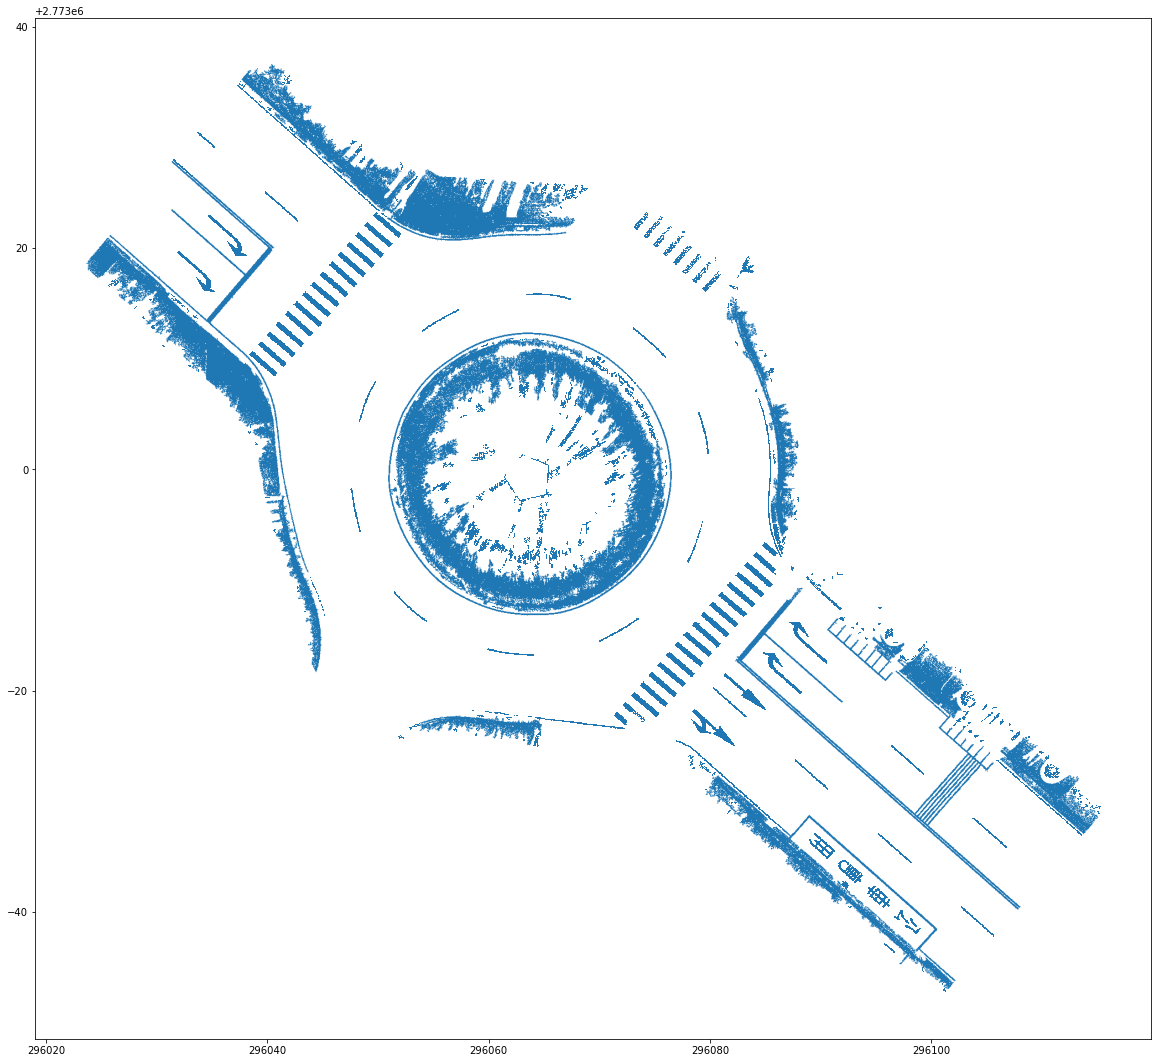

In [94]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
df_filter[df_filter.value==1].plot(ax=ax)

In [95]:
df_filter

,value,geometry
0,-1,"POLYGON ((296040.315 2773036.315, 296040.365 2..."
1,-1,"POLYGON ((296040.565 2773036.315, 296040.615 2..."
2,-1,"POLYGON ((296040.615 2773036.215, 296040.665 2..."
3,-1,"POLYGON ((296040.515 2773036.165, 296040.565 2..."
4,-1,"POLYGON ((296041.215 2773036.065, 296041.265 2..."
5,-1,"POLYGON ((296040.215 2773036.015, 296040.265 2..."
6,-1,"POLYGON ((296041.015 2773036.015, 296041.065 2..."
7,-1,"POLYGON ((296038.365 2773035.965, 296038.415 2..."
8,-1,"POLYGON ((296040.065 2773035.965, 296040.165 2..."
9,-1,"POLYGON ((296041.115 2773035.965, 296041.165 2..."


In [113]:
# fig, ax = plt.subplots(1,1, figsize=figsize)

las_data = np.array([street_las.data[i] for i in street_las.using_attr]).T

all_las_npidxs = CRS.numba_transfer_group_coord_to_npidx(las_data, geo_transform) # Wall time: 35 s



In [112]:
resolution = 0.05
pad = resolution / 2
x_min, x_max, y_min, y_max = street_las.get_las_boundary(return_poly=False)
x_min, x_max = x_min - pad, x_max + pad
y_min, y_max = y_min - pad, y_max + pad
geo_transform = (x_min, resolution, 0, y_max, 0, -resolution)
wkt_3826 = CRS.get_wkt_from_epsg(3826)
cols = int((x_max - x_min) // resolution) + 1
rows = int((y_max - y_min) // resolution) + 1
X = np.random.rand(rows, cols)
GisIO.write_output_tif(X, X_ref_fp, geo_transform=geo_transform, projection=wkt_3826, gdaldtype=gdal.GDT_Float32)
X_ref = GisIO.get_nparray(X_ref_fp)
print(X_ref.shape)

(3053, 3256, 1)


In [114]:
clipped_std = street_las.proj_las_to_2D_plane(all_las_npidxs, X_ref[:,:,0], feature='z', operator='max' )
ax.imshow(clipped_std, cmap="gray")
GisIO.write_output_tif(clipped_std, "tmp/clipped_std.tif", geo_transform=geo_transform, projection=wkt_3826,
    gdaldtype=gdal.GDT_Float64)

In [109]:
geo_transform

(295987.8332499084, 0.05, 0, 2773060.570500366, 0, -0.05)